In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 8.1 MB/s 
     |████████████████████████████████| 3.3 MB 44.7 MB/s 
     |████████████████████████████████| 636 kB 63.1 MB/s 
     |████████████████████████████████| 895 kB 62.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1', do_lower_case=True)

Loading BERT tokenizer...


In [5]:
import pandas as pd

df1 = pd.read_pickle('/content/neg_train_0.pkl')
df1.drop(columns=['Id','year'],inplace=True)
df1['label']=0
df2 = pd.read_pickle('/content/pos_train.pkl')
df2.drop(columns=['year'],inplace=True)
df2['label']=1
df = pd.concat([df1,df2])

print('Number of training sentences: {:,}\n'.format(df.shape[0]))

sentences = df.abst.values  #把 Dataframe 轉成 2D numpy array
labels = df.label.values

Number of training sentences: 1,440



In [6]:
#切資料
from sklearn.model_selection import StratifiedKFold
X_train, X_val, y_train, y_val = [],[],[],[]
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(sentences,labels):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train.append(sentences[train_index])
  X_val.append(sentences[test_index])
  y_train.append(labels[train_index])
  y_val.append(labels[test_index])

print("sentence_train長度:",len(X_train)," label_train長度:",len(y_train))
print("sentence_val長度:",len(X_val)," label_val長度:",len(y_val))

TRAIN: [ 144  145  146 ... 1437 1438 1439] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737
 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755
 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773
 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791
 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809
 8

In [7]:
#tokenize
input_ids_train,attention_masks_train =[],[]
input_ids_val,attention_masks_val = [],[]
for X_t in X_train:
  input_ids_train_list,attention_masks_train_list = [],[] 
  for sent in X_t:
    encoded_dict = tokenizer.encode_plus(sent,add_special_tokens = True, max_length = 512, pad_to_max_length = True,return_attention_mask = True, return_tensors = 'pt', )
    input_ids_train_list.append(encoded_dict['input_ids'])
    attention_masks_train_list.append(encoded_dict['attention_mask'])
  input_ids_train_list = torch.cat(input_ids_train_list, dim=0)
  attention_masks_train_list = torch.cat(attention_masks_train_list, dim=0)
  labels_train = torch.tensor(y_train)
  input_ids_train.append(input_ids_train_list)
  attention_masks_train.append(attention_masks_train_list)
  
for X_v in X_val:
  input_ids_val_list,attention_masks_val_list = [],[]
  for sent in X_v:
    encoded_dict = tokenizer.encode_plus(sent,add_special_tokens = True, max_length = 512, pad_to_max_length = True,return_attention_mask = True, return_tensors = 'pt', )
    input_ids_val_list.append(encoded_dict['input_ids'])
    attention_masks_val_list.append(encoded_dict['attention_mask'])
  input_ids_val_list = torch.cat(input_ids_val_list, dim=0)
  attention_masks_val_list = torch.cat(attention_masks_val_list, dim=0)
  labels_val = torch.tensor(y_val)
  input_ids_val.append(input_ids_val_list)
  attention_masks_val.append(attention_masks_val_list)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [8]:
#定義參數

import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [34]:
#train
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig

torch.cuda.empty_cache()
epochs = 4
training_stats = []

total_t0 = time.time()
for data in range(len(input_ids_train)): #range(1): #range(len(input_ids_train)):

  model = BertForSequenceClassification.from_pretrained(
      "dmis-lab/biobert-base-cased-v1.1",
      num_labels = 2,output_attentions = False,
      output_hidden_states = False ,
      #attention_probs_dropout_prob=0.55,
      #hidden_dropout_prob=0.55 
      )
  model.cuda()

  train_dataset = TensorDataset(input_ids_train[data], attention_masks_train[data], labels_train[data])
  val_dataset = TensorDataset(input_ids_val[data], attention_masks_val[data], labels_val[data])
  batch_size = 8 
  train_dataloader = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),batch_size = batch_size)
  validation_dataloader = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),batch_size = batch_size)

  optimizer = AdamW(model.parameters(),lr = 2e-5,eps = 1e-8)
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,num_training_steps = total_steps)

  training_stats_list = []

  for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time() 
    total_train_loss = 0
    model.train()
    #TRAIN
    for step, batch in enumerate(train_dataloader):
      if step % 40 == 0 and not step == 0:
          elapsed = format_time(time.time() - t0)
          print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed)) 
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      model.zero_grad()        
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels) 
      loss = output[0]
      logits = output[1] 
      total_train_loss += loss.item()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)                 
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    #VALIDATION
    for batch in validation_dataloader:         
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,labels=b_labels)            
        loss = outputs[0]
        logits = outputs[1]
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)   
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)   
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    #TEST
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Testing...')
    t0 = time.time() 
    total_test_loss = 0
    total_test_accuracy = 0
    for batch in train_dataloader:      
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      with torch.no_grad():        
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels) 
      loss = output[0]
      logits = output[1] 
      total_test_loss += loss.item()
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      total_test_accuracy += flat_accuracy(logits, label_ids)


    avg_test_accuracy = total_test_accuracy / len(train_dataloader)   
    print(" TEST Accuracy: {0:.2f}".format(avg_test_accuracy))
    avg_test_loss = total_test_loss / len(train_dataloader)   
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.2f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))



    training_stats_list.append({'epoch': epoch_i + 1,'Training Loss': avg_train_loss,
                  'Valid. Loss': avg_val_loss,'Test Loss':avg_test_loss,
                  'Valid. Accur.': avg_val_accuracy,'Test Accur.': avg_test_accuracy,
                  'Training Time': training_time,'Validation Time': validation_time,
                  'Test Time':test_time})
  training_stats.append(training_stats_list)

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    144.    Elapsed: 0:00:30.
  Batch    80  of    144.    Elapsed: 0:01:01.
  Batch   120  of    144.    Elapsed: 0:01:32.

  Average training loss: 0.45
  Training epcoh took: 0:01:51

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.35
  Validation took: 0:00:10

======== Epoch 1 / 4 ========
Testing...
 TEST Accuracy: 0.90
  Test Loss: 0.25
  Test took: 0:00:41

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    144.    Elapsed: 0:00:33.
  Batch    80  of    144.    Elapsed: 0:01:05.
  Batch   120  of    144.    Elapsed: 0:01:38.

  Average training loss: 0.27
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.59
  Validation took: 0:00:10

======== Epoch 2 / 4 ========
Testing...
 TEST Accuracy: 0.92
  Test Loss: 0.26
  Test took: 0:00:41

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    144.    Elapsed: 0:00:33.
  Batch    80  of    144.    Ela

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    144.    Elapsed: 0:00:33.
  Batch    80  of    144.    Elapsed: 0:01:05.
  Batch   120  of    144.    Elapsed: 0:01:38.

  Average training loss: 0.46
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.46
  Validation took: 0:00:10

======== Epoch 1 / 4 ========
Testing...
 TEST Accuracy: 0.90
  Test Loss: 0.26
  Test took: 0:00:41

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    144.    Elapsed: 0:00:32.
  Batch    80  of    144.    Elapsed: 0:01:05.
  Batch   120  of    144.    Elapsed: 0:01:38.

  Average training loss: 0.25
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.36
  Validation took: 0:00:10

======== Epoch 2 / 4 ========
Testing...
 TEST Accuracy: 0.97
  Test Loss: 0.12
  Test took: 0:00:41

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    144.    Elapsed: 0:00:33.
  Batch    80  of    144.    Ela

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    144.    Elapsed: 0:00:33.
  Batch    80  of    144.    Elapsed: 0:01:05.
  Batch   120  of    144.    Elapsed: 0:01:38.

  Average training loss: 0.42
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.35
  Validation took: 0:00:10

======== Epoch 1 / 4 ========
Testing...
 TEST Accuracy: 0.93
  Test Loss: 0.23
  Test took: 0:00:41

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    144.    Elapsed: 0:00:32.
  Batch    80  of    144.    Elapsed: 0:01:05.
  Batch   120  of    144.    Elapsed: 0:01:38.

  Average training loss: 0.26
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.39
  Validation took: 0:00:10

======== Epoch 2 / 4 ========
Testing...
 TEST Accuracy: 0.96
  Test Loss: 0.14
  Test took: 0:00:41

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    144.    Elapsed: 0:00:33.
  Batch    80  of    144.    Ela

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    144.    Elapsed: 0:00:32.
  Batch    80  of    144.    Elapsed: 0:01:05.
  Batch   120  of    144.    Elapsed: 0:01:38.

  Average training loss: 0.43
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.36
  Validation took: 0:00:10

======== Epoch 1 / 4 ========
Testing...
 TEST Accuracy: 0.90
  Test Loss: 0.26
  Test took: 0:00:41

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    144.    Elapsed: 0:00:33.
  Batch    80  of    144.    Elapsed: 0:01:05.
  Batch   120  of    144.    Elapsed: 0:01:38.

  Average training loss: 0.24
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.49
  Validation took: 0:00:10

======== Epoch 2 / 4 ========
Testing...
 TEST Accuracy: 0.94
  Test Loss: 0.19
  Test took: 0:00:41

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    144.    Elapsed: 0:00:33.
  Batch    80  of    144.    Ela

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    144.    Elapsed: 0:00:33.
  Batch    80  of    144.    Elapsed: 0:01:05.
  Batch   120  of    144.    Elapsed: 0:01:38.

  Average training loss: 0.44
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.32
  Validation took: 0:00:10

======== Epoch 1 / 4 ========
Testing...
 TEST Accuracy: 0.91
  Test Loss: 0.23
  Test took: 0:00:41

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    144.    Elapsed: 0:00:32.
  Batch    80  of    144.    Elapsed: 0:01:05.
  Batch   120  of    144.    Elapsed: 0:01:38.

  Average training loss: 0.27
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.37
  Validation took: 0:00:10

======== Epoch 2 / 4 ========
Testing...
 TEST Accuracy: 0.96
  Test Loss: 0.15
  Test took: 0:00:41

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    144.    Elapsed: 0:00:33.
  Batch    80  of    144.    Ela

In [35]:
#訓練總結
import pandas as pd
answer,total_avg_test_loss_list,total_avg_val_loss_list,total_avg_val_accuracy_list,total_avg_test_accuracy_list = [],[],[],[],[]
for data in range(len(input_ids_train)): #range(1): #range(len(input_ids_train)):
  print("n_splits :",data+1)
  pd.set_option('precision', 2)
  df_stats = pd.DataFrame(data=training_stats[data])
  df_stats = df_stats.set_index('epoch')
  print(df_stats.head())
  answer.append(df_stats)

  
  for epoch_i in range(0, epochs):
    total_avg_test_loss_list.append(answer[data]['Test Loss'][epoch_i+1])
    total_avg_val_loss_list.append(answer[data]['Valid. Loss'][epoch_i+1])
    total_avg_val_accuracy_list.append(answer[data]['Valid. Accur.'][epoch_i+1])
    total_avg_test_accuracy_list.append(answer[data]['Test Accur.'][epoch_i+1])
  
total_avg_test_loss =[sum(total_avg_test_loss_list[0::4])/len(total_avg_test_loss_list[0::4]),
              sum(total_avg_test_loss_list[1::4])/len(total_avg_test_loss_list[1::4]),
              sum(total_avg_test_loss_list[2::4])/len(total_avg_test_loss_list[2::4]),
              sum(total_avg_test_loss_list[3::4])/len(total_avg_test_loss_list[3::4])]
total_avg_val_loss =[sum(total_avg_val_loss_list[0::4])/len(total_avg_val_loss_list[0::4]),
              sum(total_avg_val_loss_list[1::4])/len(total_avg_val_loss_list[1::4]),
              sum(total_avg_val_loss_list[2::4])/len(total_avg_val_loss_list[2::4]),
              sum(total_avg_val_loss_list[3::4])/len(total_avg_val_loss_list[3::4])]
total_avg_val_accuracy =[sum(total_avg_val_accuracy_list[0::4])/len(total_avg_val_accuracy_list[0::4]),
              sum(total_avg_val_accuracy_list[1::4])/len(total_avg_val_accuracy_list[1::4]),
              sum(total_avg_val_accuracy_list[2::4])/len(total_avg_val_accuracy_list[2::4]),
              sum(total_avg_val_accuracy_list[3::4])/len(total_avg_val_accuracy_list[3::4])]
total_avg_test_accuracy =[sum(total_avg_test_accuracy_list[0::4])/len(total_avg_test_accuracy_list[0::4]),
              sum(total_avg_test_accuracy_list[1::4])/len(total_avg_test_accuracy_list[1::4]),
              sum(total_avg_test_accuracy_list[2::4])/len(total_avg_test_accuracy_list[2::4]),
              sum(total_avg_test_accuracy_list[3::4])/len(total_avg_test_accuracy_list[3::4])]                     

n_splits : 1
       Training Loss  Valid. Loss  ...  Validation Time  Test Time
epoch                              ...                            
1               0.45         0.35  ...          0:00:10    0:00:41
2               0.27         0.59  ...          0:00:10    0:00:41
3               0.18         0.54  ...          0:00:10    0:00:41
4               0.11         0.58  ...          0:00:10    0:00:41

[4 rows x 8 columns]
n_splits : 2
       Training Loss  Valid. Loss  ...  Validation Time  Test Time
epoch                              ...                            
1               0.46         0.46  ...          0:00:10    0:00:41
2               0.25         0.36  ...          0:00:10    0:00:41
3               0.14         0.44  ...          0:00:10    0:00:41
4               0.07         0.48  ...          0:00:10    0:00:41

[4 rows x 8 columns]
n_splits : 3
       Training Loss  Valid. Loss  ...  Validation Time  Test Time
epoch                              ...        

In [36]:
df_stats.head()

,Training Loss,Valid. Loss,Test Loss,Valid. Accur.,Test Accur.,Training Time,Validation Time,Test Time
epoch,,,,,,,,
1,0.44,0.32,0.23,0.87,0.91,0:01:57,0:00:10,0:00:41
2,0.27,0.37,0.15,0.89,0.96,0:01:57,0:00:10,0:00:41
3,0.17,0.46,0.12,0.88,0.97,0:01:57,0:00:10,0:00:41
4,0.09,0.49,0.08,0.88,0.98,0:01:57,0:00:10,0:00:41


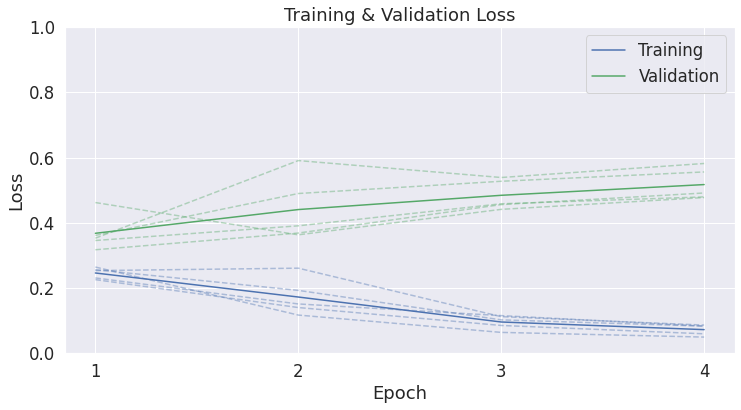

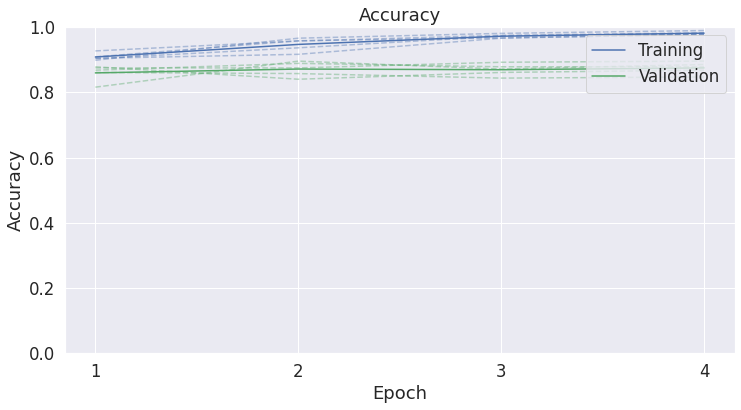

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

#Loss
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4])
plt.ylim(0, 1)
x=[1,2,3,4]
for i in range(len(input_ids_train)): #range(len(input_ids_train)):
  plt.plot(x,answer[i]['Test Loss'], 'b--', alpha=0.4)
  plt.plot(x,answer[i]['Valid. Loss'], 'g--', alpha=0.4)
  
plt.plot(x,total_avg_test_loss,'b',label="Training")
plt.plot(x,total_avg_val_loss,'g',label="Validation")
plt.legend(loc='upper right')
plt.show()

#Accuracy
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks([1, 2, 3, 4])
plt.ylim(0, 1)
x=[1,2,3,4]
for i in range(len(input_ids_train)): #range(len(input_ids_train)):
  plt.plot(x,answer[i]['Test Accur.'], 'b--', alpha=0.4)
  plt.plot(x,answer[i]['Valid. Accur.'], 'g--', alpha=0.4)

plt.plot(x,total_avg_test_accuracy,'b',label="Training")
plt.plot(x,total_avg_val_accuracy,'g',label="Validation")
plt.legend(loc='upper right')  
plt.show()